In [20]:
import numpy as np
import matplotlib.pyplot as plt
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import DigitalAnalogDevice
from pulser.waveforms import InterpolatedWaveform
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform

In [21]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

def coordinates_to_Q(coords, C6=DigitalAnalogDevice.interaction_coeff, diag_val=-10.0):
    """
    Given a list of 2D coordinates, return a QUBO matrix Q.
    
    Args:
        coords: np.array of shape (n, 2)
        C6: interaction coefficient (default in Hz·μm⁶)
        diag_val: value to set for diagonal elements

    Returns:
        Q matrix (n x n)
    """
    coords = np.array(coords)
    distances = squareform(pdist(coords))  # Shape (n, n)
    with np.errstate(divide='ignore'):
        interaction = np.where(distances != 0, C6 / distances**6, 0.0)

    Q = interaction.copy()
    np.fill_diagonal(Q, diag_val)
    return Q

In [22]:
import numpy as np

def generate_pascal_triangle_coords(num_atoms, min_distance=4.0):
    """
    Generate coordinates in a Pascal Triangle layout.

    Args:
        num_atoms (int): Total number of atoms. 
                         Values 1, 3, 6, 10, or 11/12 supported (extra atoms added reasonably).
        min_distance (float): Minimum spacing between atoms.

    Returns:
        coords (np.ndarray): Array of shape (n, 2) with 2D coordinates.
    """
    triangle_numbers = {1, 3, 6, 10}
    coords = []
    h = min_distance * np.sqrt(3) / 2  # Vertical spacing for equilateral triangle

    # Handle exact triangle numbers
    if num_atoms in triangle_numbers:
        n = int((np.sqrt(8 * num_atoms + 1) - 1) / 2)
        for row in range(n):
            num_in_row = row + 1
            x_offset = - (num_in_row - 1) * min_distance / 2
            y = -row * h
            for i in range(num_in_row):
                x = x_offset + i * min_distance
                coords.append((x, y))

    elif num_atoms == 11:
        # 10 from full triangle + 1 at center bottom
        coords = generate_pascal_triangle_coords(10, min_distance).tolist()
        coords.append((0.0, -4 * h))  # Add one atom center bottom

    elif num_atoms == 12:
        # 10 from full triangle + 1 left-bottom + 1 right-bottom
        coords = generate_pascal_triangle_coords(10, min_distance).tolist()
        coords.append((-min_distance, -4 * h))  # Left of bottom row
        coords.append((min_distance, -4 * h))   # Right of bottom row

    else:
        raise ValueError("Only supports 1, 3, 6, 10, 11, or 12 atoms for Pascal triangle layout.")

    return np.array(coords)

In [23]:
pascal_triangle = generate_pascal_triangle_coords(12, min_distance=5.0)


Q1 = coordinates_to_Q(pascal_triangle)
print(Q1)

[[-1.00000000e+01  3.46890146e+02  3.46890146e+02  5.42015853e+00
   1.28477832e+01  5.42015853e+00  4.75843822e-01  1.01134153e+00
   1.01134153e+00  4.75843822e-01  1.57892647e-01  1.57892647e-01]
 [ 3.46890146e+02 -1.00000000e+01  3.46890146e+02  3.46890146e+02
   3.46890146e+02  1.28477832e+01  5.42015853e+00  1.28477832e+01
   5.42015853e+00  1.01134153e+00  1.01134153e+00  4.75843822e-01]
 [ 3.46890146e+02  3.46890146e+02 -1.00000000e+01  1.28477832e+01
   3.46890146e+02  3.46890146e+02  1.01134153e+00  5.42015853e+00
   1.28477832e+01  5.42015853e+00  4.75843822e-01  1.01134153e+00]
 [ 5.42015853e+00  3.46890146e+02  1.28477832e+01 -1.00000000e+01
   3.46890146e+02  5.42015853e+00  3.46890146e+02  3.46890146e+02
   1.28477832e+01  1.01134153e+00  1.28477832e+01  1.01134153e+00]
 [ 1.28477832e+01  3.46890146e+02  3.46890146e+02  3.46890146e+02
  -1.00000000e+01  3.46890146e+02  1.28477832e+01  3.46890146e+02
   3.46890146e+02  1.28477832e+01  5.42015853e+00  5.42015853e+00]
 [ 5.

In [24]:
Q = np.array(
    [
        [-10.0, 19.7365809, 19.7365809, 5.42015853, 5.42015853],
        [19.7365809, -10.0, 20.67626392, 0.17675796, 0.85604541],
        [19.7365809, 20.67626392, -10.0, 0.85604541, 0.17675796],
        [5.42015853, 0.17675796, 0.85604541, -10.0, 0.32306662],
        [5.42015853, 0.85604541, 0.17675796, 0.32306662, -10.0],
    ]
)

Q = Q1

In [25]:
bitstrings = [np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))]
costs = []
# this takes exponential time with the dimension of the QUBO
for b in bitstrings:
    z = np.array(list(b), dtype=int)
    cost = z.T @ Q @ z
    costs.append(cost)
zipped = zip(bitstrings, costs)
sort_zipped = sorted(zipped, key=lambda x: x[1])
print(sort_zipped[:3])
top_bitstrings = [bitstring for bitstring, cost in sort_zipped[:2]]

[('100000100100', -27.14493707061728), ('100000000110', -26.709843995863842), ('100000100001', -26.709843995863842)]


In [26]:
def evaluate_mapping(new_coords, Q):
    """Cost function to minimize. Ideally, the pairwise distances are conserved."""
    new_coords = np.reshape(new_coords, (len(Q), 2))
    # computing the matrix of the distances between all coordinate pairs
    new_Q = squareform(
        DigitalAnalogDevice.interaction_coeff / pdist(new_coords) ** 6
    )
    return np.linalg.norm(new_Q - Q)

In [27]:

costs = []
np.random.seed(0)
#x0 = np.random.random(len(Q) * 2)

x0 = pascal_triangle.flatten()
res = minimize(
    evaluate_mapping,
    x0,
    args=(Q,),
    method="Nelder-Mead",
    tol=1e-6,
    options={"maxiter": 200000, "maxfev": None},
)

coords = np.reshape(res.x, (len(Q), 2))

In [28]:
# Recompute new_Q using the optimal coordinates
final_coords = np.reshape(res.x, (len(Q), 2))
final_distances = pdist(final_coords)
final_new_Q = squareform(DigitalAnalogDevice.interaction_coeff / final_distances ** 6)

# Print the matrix
print("Final new_Q matrix (interaction strengths):")
print(final_new_Q)
print(res.x)

Final new_Q matrix (interaction strengths):
[[0.00000000e+00 3.46890146e+02 3.46890146e+02 5.42015853e+00
  1.28477832e+01 5.42015853e+00 4.75843822e-01 1.01134153e+00
  1.01134153e+00 4.75843822e-01 1.57892647e-01 1.57892647e-01]
 [3.46890146e+02 0.00000000e+00 3.46890146e+02 3.46890146e+02
  3.46890146e+02 1.28477832e+01 5.42015853e+00 1.28477832e+01
  5.42015853e+00 1.01134153e+00 1.01134153e+00 4.75843822e-01]
 [3.46890146e+02 3.46890146e+02 0.00000000e+00 1.28477832e+01
  3.46890146e+02 3.46890146e+02 1.01134153e+00 5.42015853e+00
  1.28477832e+01 5.42015853e+00 4.75843822e-01 1.01134153e+00]
 [5.42015853e+00 3.46890146e+02 1.28477832e+01 0.00000000e+00
  3.46890146e+02 5.42015853e+00 3.46890146e+02 3.46890146e+02
  1.28477832e+01 1.01134153e+00 1.28477832e+01 1.01134153e+00]
 [1.28477832e+01 3.46890146e+02 3.46890146e+02 3.46890146e+02
  0.00000000e+00 3.46890146e+02 1.28477832e+01 3.46890146e+02
  3.46890146e+02 1.28477832e+01 5.42015853e+00 5.42015853e+00]
 [5.42015853e+00 1.28

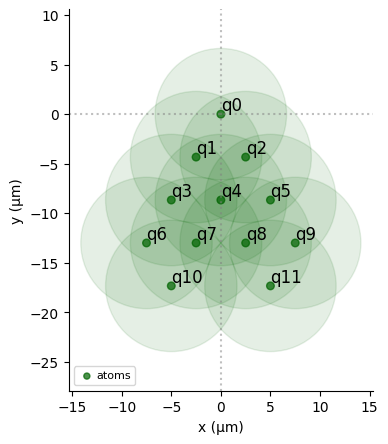

In [29]:
qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}
reg = Register(qubits)
reg.draw(
    blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1.0),
    draw_graph=False,
    draw_half_radius=True,
)

In [30]:
def plot_distribution(C, highlight_bitstrings):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    #indexes = ["01011", "00111"]  # QUBO solutions
    color_dict = {key: "r" if key in highlight_bitstrings else "g" for key in C}
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical")
    plt.show()

In [31]:
def get_cost_colouring(bitstring, Q):
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z
    return cost


def get_cost(counter, Q):
    cost = sum(counter[key] * get_cost_colouring(key, Q) for key in counter)
    return cost / sum(counter.values())  # Divide by total samples

In [32]:
def func(param, *args):
    Q = args[0]
    C = quantum_loop(param)
    cost = get_cost(C, Q)
    return cost

In [ ]:
# We choose a median value between the min and the max
Omega = np.median(Q[Q > 0].flatten())
delta_0 = -5  # just has to be negative
delta_f = -delta_0  # just has to be positive
T = 2000  # time in ns, we choose a time long enough to ensure the propagation of information in the system

12

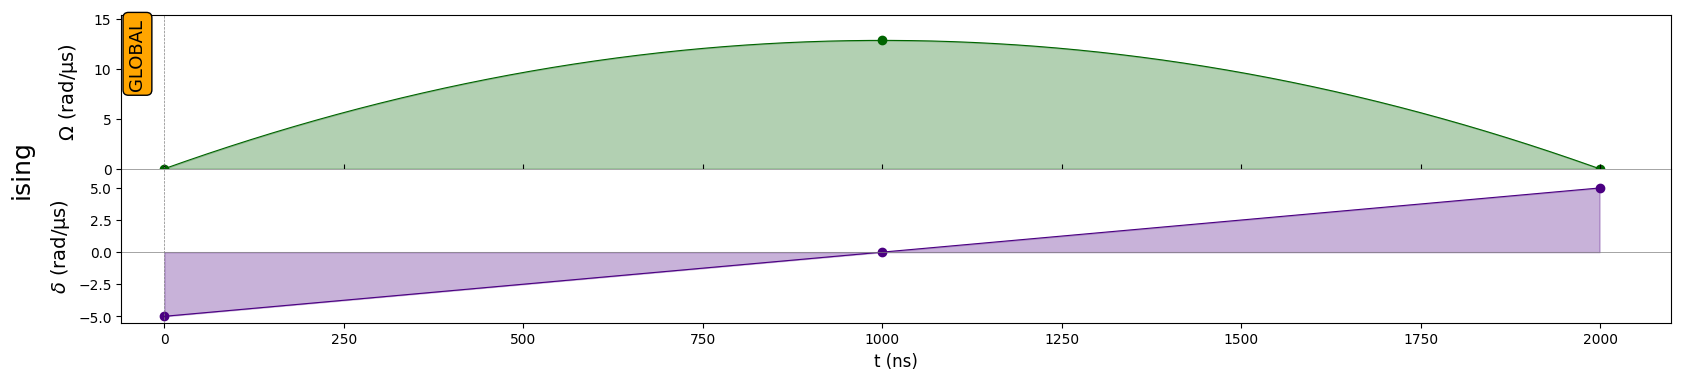

In [34]:
adiabatic_pulse = Pulse(
    InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
    InterpolatedWaveform(T, [delta_0, 0, delta_f]),
    0,
)
seq = Sequence(reg, DigitalAnalogDevice)
seq.declare_channel("ising", "rydberg_global")
seq.add(adiabatic_pulse, "ising")
seq.draw()

In [35]:
simul = QutipEmulator.from_sequence(seq)
results = simul.run()
final = results.get_final_state()
count_dict = results.sample_final_state()

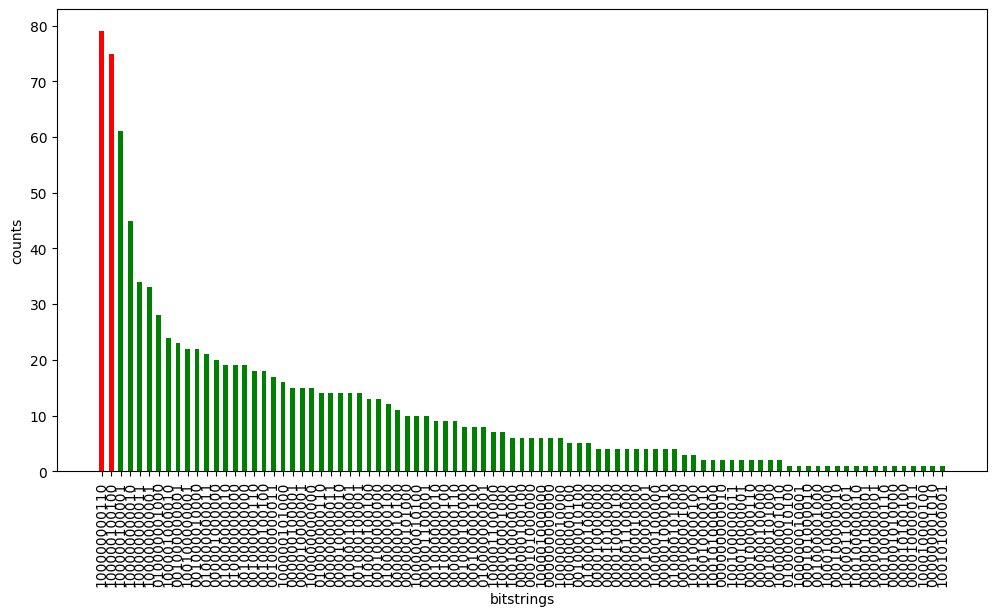

In [36]:
plot_distribution(count_dict, top_bitstrings)

In [19]:
cost = []
for T in 1000 * np.linspace(1, 10, 10):
    seq = Sequence(reg, DigitalAnalogDevice)
    seq.declare_channel("ising", "rydberg_global")
    adiabatic_pulse = Pulse(
        InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
        InterpolatedWaveform(T, [delta_0, 0, delta_f]),
        0,
    )
    seq.add(adiabatic_pulse, "ising")
    simul = QutipEmulator.from_sequence(seq)
    results = simul.run()
    final = results.get_final_state()
    count_dict = results.sample_final_state()
    cost.append(get_cost(count_dict, Q) / 3)

KeyboardInterrupt: 

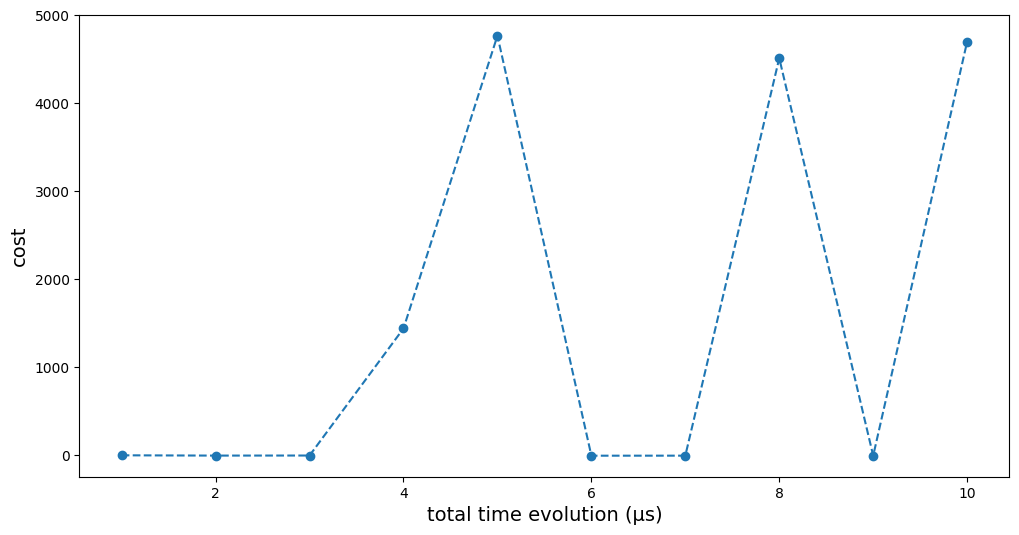

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), np.array(cost), "--o")
plt.xlabel("total time evolution (µs)", fontsize=14)
plt.ylabel("cost", fontsize=14)
plt.show()
